# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(42)
np.random.seed(42)

## Device Configuration


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

 

This cell handles the loading and preprocessing of the MNIST dataset.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 58.1kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]


In [5]:
def show_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i].cpu().squeeze(), cmap='gray')
            ax.set_title(f"Label: {labels[i].item()}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

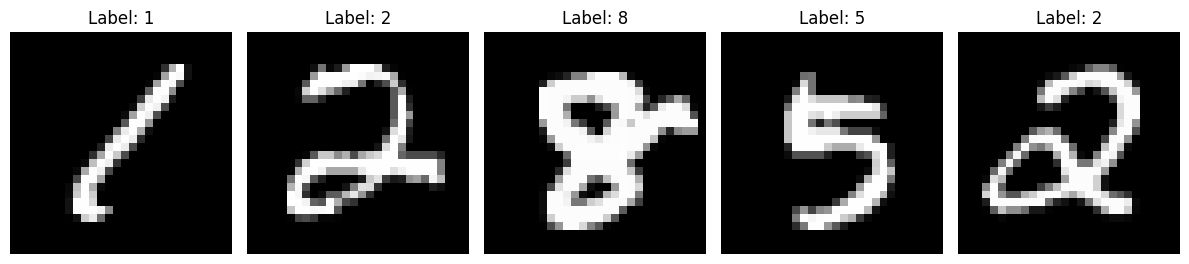

In [6]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images, labels)

## Diffusion Process Implementation

This cell defines the `DiffusionProcess` class, which encapsulates the mathematics of the forward and reverse diffusion processes.

 `__init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02)`

Initializes the diffusion parameters.
-   `timesteps` ($T$): The total number of diffusion steps.
-   `beta_start`, `beta_end`: The start and end values for the variance schedule $\beta_t$.
-   **Noise Schedule (`self.betas`)**:
    A linear schedule for $\beta_t$ is created:
    $$\beta_t = \text{linspace}(\beta_{\text{start}}, \beta_{\text{end}}, T)$$
    These $\beta_t$ values represent the variance of the noise added at each step $t$ in the forward process.
-   **Alphas (`self.alphas`, `self.alphas_cumprod`, `self.alphas_cumprod_prev`)**:
    These are derived from $\beta_t$ and are crucial for the diffusion formulas.
    *   $\alpha_t = 1 - \beta_t$
    *   $\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$ (cumulative product of alphas, `self.alphas_cumprod`)
    *   $\bar{\alpha}_{t-1}$ (`self.alphas_cumprod_prev`): The cumulative product up to the previous step. `F.pad` is used to set $\bar{\alpha}_0 = 1$.
-   **Precomputed Constants**:
    Various terms are precomputed for efficiency in the sampling functions:
    *   $\sqrt{\bar{\alpha}_t}$ (`self.sqrt_alphas_cumprod`)
    *   $\sqrt{1 - \bar{\alpha}_t}$ (`self.sqrt_one_minus_alphas_cumprod`)
    *   $\sqrt{1/\alpha_t}$ (`self.sqrt_recip_alphas`)
    *   **Posterior Variance (`self.posterior_variance`)**: The variance of $q(x_{t-1} | x_t, x_0)$, which is $\tilde{\beta}_t = \beta_t \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}$. This is used in the reverse (denoising) step.

`q_sample(self, x_0, t, noise=None)`


Implements the forward diffusion process $q(x_t | x_0)$. This function takes an original clean image $x_0$ and a timestep $t$, and returns a noisy version $x_t$.
-   The formula for $x_t$ given $x_0$ is:
    $$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$$
    where $\epsilon \sim \mathcal{N}(0, I)$ is random noise.
-   `noise`: If `None`, standard Gaussian noise is generated. Otherwise, provided noise is used.
-   `sqrt_alphas_cumprod_t` and `sqrt_one_minus_alphas_cumprod_t` are selected for the given timesteps `t` and reshaped for broadcasting with the image `x_0`.

`p_sample(self, model, x_t, t, label=None)`


Performs a single step in the reverse diffusion (denoising) process $p_\theta(x_{t-1} | x_t)$. This function takes a noisy image $x_t$ at timestep $t$, the denoising model, and predicts a slightly less noisy image $x_{t-1}$.
-   Operates under `torch.no_grad()` as this is an inference step.
-   **Predict Noise**:
    The `model` (typically a U-Net) predicts the noise $\epsilon_\theta(x_t, t, \text{label})$ that was added to form $x_t$.
-   **Compute Model Mean**:
    The mean of $p_\theta(x_{t-1} | x_t)$ is calculated as:
    $$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t, \text{label}) \right)$$
-   **Add Posterior Variance**:
    If $t > 0$, noise is added to the mean, sampled from a Gaussian with variance $\tilde{\beta}_t$ (the `posterior_variance_t`).
    $$x_{t-1} = \mu_\theta(x_t, t) + \sqrt{\tilde{\beta}_t} z$$
    where $z \sim \mathcal{N}(0, I)$.
    If $t = 0$, the model mean is returned directly (no more noise is added).
-   `label`: Optional conditioning label passed to the model.

`p_sample_loop(self, model, shape, label=None, num_samples=1)`


Implements the full reverse diffusion process to generate an image from pure noise.
-   `batch_size`: Determined by the `label` batch size if provided, otherwise `num_samples`.
-   `x_t`: Starts as pure Gaussian noise $x_T \sim \mathcal{N}(0, I)$ with the specified `shape`.
-   The loop iterates from $t = T-1$ down to $0$.
-   In each iteration:
    *   `t_batch`: A tensor of the current timestep `t_val` is created, matching the `batch_size`.
    *   `self.p_sample()`: The single-step denoising function is called to get $x_{t-1}$ from $x_t$.
-   A `tqdm` progress bar shows the sampling progress.
-   Returns the fully denoised image $x_0$.


In [ ]:
class DiffusionProcess:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        """
        Initialize the diffusion process

        Args:
            timesteps: Number of diffusion steps
            beta_start: Starting noise schedule value
            beta_end: Ending noise schedule value
        """
        self.timesteps = timesteps

        # Define noise schedule (linear schedule)
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)

        # Calculate alphas and related quantities
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # Constants to easily compute noise and denoising
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def q_sample(self, x_0, t, noise=None):
        """
        Forward diffusion process: add noise to the original image

        Args:
            x_0: Original clean image
            t: Timestep
            noise: Optional pre-generated noise

        Returns:
            Noisy image at timestep t
        """
        if noise is None:
            noise = torch.randn_like(x_0)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)

        return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

    def p_sample(self, model, x_t, t, label=None):
        """
        Single step of the reverse diffusion (denoising) process

        Args:
            model: Denoising model
            x_t: Noisy image at timestep t
            t: Current timestep
            label: Conditioning label

        Returns:
            Denoised image at timestep t-1
        """
        with torch.no_grad():
            betas_t = self.betas[t].reshape(-1, 1, 1, 1)
            sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
            sqrt_recip_alphas_t = self.sqrt_recip_alphas[t].reshape(-1, 1, 1, 1)

            # Predict the noise component
            predicted_noise = model(x_t, t, label)

            # Compute the mean for p(x_{t-1} | x_t)
            model_mean = sqrt_recip_alphas_t * (x_t - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)

            # Add noise to the mean if t > 0, else just return the mean
            if t[0] > 0:
                noise = torch.randn_like(x_t)
                posterior_variance_t = self.posterior_variance[t].reshape(-1, 1, 1, 1)
                return model_mean + torch.sqrt(posterior_variance_t) * noise
            else:
                return model_mean

    def p_sample_loop(self, model, shape, label=None, num_samples=1):
        """
        Complete reverse diffusion (sampling) process

        Args:
            model: Denoising model
            shape: Shape of the image to generate
            label: Conditioning label
            num_samples: Number of samples to generate

        Returns:
            Generated samples
        """
        batch_size = label.shape[0] if label is not None else num_samples
        x_t = torch.randn(batch_size, *shape, device=device)

        progress_bar = tqdm(reversed(range(0, self.timesteps)), total=self.timesteps)
        for t in progress_bar:
            # Create batch of same timestep t for the entire batch
            t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)

            # Denoising step
            x_t = self.p_sample(model, x_t, t_batch, label)

            progress_bar.set_description(f"Sampling timestep {t}")

        return x_t



### 7. Sinusoidal Position Embeddings
Encodes the timestep $t$ into a fixed-size vector using sinusoidal functions, similar to Transformer embeddings.
-   For a dimension $d_{\text{model}}$ (`self.dim`), the embedding components are:
    $$PE_{(t, 2i)} = \sin(t / 10000^{2i/d_{\text{model}}})$$
    $$PE_{(t, 2i+1)} = \cos(t / 10000^{2i/d_{\text{model}}})$$
    These are concatenated to form the final embedding.

In [8]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal position embeddings for timestep
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


### 8. Convolutional Block
A basic building block for the U-Net, consisting of two convolutional layers, Group Normalization, SiLU activation, and residual connection. It can incorporate time and label embeddings by projecting them and adding them to the feature maps.


In [9]:
class Block(nn.Module):
    """
    Basic convolutional block
    """
    def __init__(self, in_ch, out_ch, time_emb_dim=None, num_classes=None):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch) if time_emb_dim is not None else None
        self.label_emb = nn.Embedding(num_classes, out_ch) if num_classes is not None else None

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()

        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, time_emb=None, label=None):
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)

        # Add time embedding if provided
        if self.time_mlp is not None and time_emb is not None:
            time_condition = self.time_mlp(time_emb)
            h = h + time_condition.reshape(time_condition.shape[0], -1, 1, 1)

        # Add label embedding if provided
        if self.label_emb is not None and label is not None:
            label_condition = self.label_emb(label)
            h = h + label_condition.reshape(label_condition.shape[0], -1, 1, 1)

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)

        return h + self.residual(x)


## Conditional U-Net Model

This cell defines the `ConditionalUNet` class, which is the core neural network architecture used to predict the noise in the diffusion model. It's a U-Net structure adapted for conditional generation (time and label).

-   **`__init__(self, in_channels=1, model_channels=64, out_channels=1, num_classes=10, time_emb_dim=128, dropout=0.1)`**:
    *   `in_channels`: Number of input image channels (1 for MNIST).
    *   `model_channels`: Base number of channels in the first convolutional layer. Subsequent layers will often have multiples of this.
    *   `out_channels`: Number of output channels (1, as it predicts the noise which has the same channels as the input image).
    *   `num_classes`: Number of classes for label conditioning (10 for MNIST digits).
    *   `time_emb_dim`: Dimensionality of the time embedding.
    *   `dropout`: Dropout rate.
    *   **Time Embedding (`self.time_embedding`)**: An `nn.Sequential` module that first applies `SinusoidalPositionEmbeddings` and then passes it through two linear layers with a SiLU activation in between. This further processes the raw sinusoidal embeddings.
    *   **Label Embedding (`self.label_embedding`)**: An `nn.Embedding` layer that converts class labels (integers) into dense vectors of size `time_emb_dim`. The output dimension is chosen to match `time_emb_dim` to allow easy combination (e.g., addition).
    *   **Initial Convolution (`self.init_conv`)**: A `Conv2d` layer that processes the input image `x` and maps it to `model_channels`.
    *   **Downsampling Path (Encoder)**:
        *   `self.down1`, `self.down2`, `self.down3`: Instances of the `Block` module. The number of channels typically increases in deeper layers (e.g., `model_channels` -> `2*model_channels` -> `4*model_channels`). These blocks also receive the time and label embeddings for conditioning.
        *   `self.downsample1`, `self.downsample2`: `nn.MaxPool2d(2)` layers to halve the spatial dimensions of the feature maps.
    *   **Middle (Bottleneck)**:
        *   `self.middle1`, `self.middle2`: `Block` instances that operate at the lowest spatial resolution in the U-Net.
    *   **Upsampling Path (Decoder)**:
        *   `self.upsample1`, `self.upsample2`: `nn.Upsample(scale_factor=2, mode='nearest')` layers to double the spatial dimensions.
        *   `self.up1`, `self.up2`: `Block` instances for the decoder.
        *   **Skip Connections**: The input to these upsampling blocks includes feature maps concatenated from the corresponding downsampling path (e.g., output of `self.upsample1` is concatenated with output of `self.down2` before passing to `self.up1`). This is a hallmark of U-Net architectures, allowing the decoder to leverage low-level features from the encoder. The `in_ch` for these blocks reflect this concatenation.
    *   **Output Layer (`self.out`)**: An `nn.Sequential` module with GroupNorm, SiLU, and a final `Conv2d` layer to map the features back to the desired `out_channels` (predicting the noise).
    *   `self.dropout`: An `nn.Dropout` layer.

-   **`forward(self, x, timestep, label=None)`**:
    *   `x`: Input noisy image tensor (shape `[B, in_channels, H, W]`).
    *   `timestep`: Tensor of timesteps for each image in the batch.
    *   `label`: Tensor of labels for conditioning (optional).
    *   **Embedding Combination**:
        1.  `time_emb = self.time_embedding(timestep)`: Generates time embeddings.
        2.  If `label` is provided, `label_emb = self.label_embedding(label)` generates label embeddings.
        3.  `combined_emb = time_emb + label_emb`: Time and label embeddings are combined (here by element-wise addition). If no label, `combined_emb` is just `time_emb`.
    *   **U-Net Path**:
        1.  `x = self.init_conv(x)`
        2.  **Encoder**:
            *   `d1 = self.down1(x, combined_emb, label)`: Output of the first down block is saved for skip connection.
            *   `x = self.downsample1(d1)`
            *   `x = self.dropout(x)`
            *   Similar steps for `d2` and `down3`.
        3.  **Bottleneck**: `x` passes through `self.middle1` and `self.middle2`.
        4.  **Decoder**:
            *   `x = self.upsample1(x)`
            *   `x = self.dropout(x)`
            *   `x = torch.cat([x, d2], dim=1)`: Concatenates the upsampled feature map with the skip connection `d2` along the channel dimension (`dim=1`).
            *   `x = self.up1(x, combined_emb, label)`
            *   Similar steps for `upsample2`, `d1`, and `up2`.
        5.  `return self.out(x)`: The final output, which is the predicted noise.

In [10]:
class ConditionalUNet(nn.Module):
    """
    U-Net architecture for denoising diffusion model
    """
    def __init__(self, in_channels=1, model_channels=64, out_channels=1, num_classes=10,
                 time_emb_dim=128, dropout=0.1):
        super().__init__()

        # Time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # Label embedding
        self.label_embedding = nn.Embedding(num_classes, time_emb_dim)

        # Initial convolution
        self.init_conv = nn.Conv2d(in_channels, model_channels, 3, padding=1)

        # Downsampling
        self.down1 = Block(model_channels, model_channels, time_emb_dim, num_classes)
        self.down2 = Block(model_channels, 2 * model_channels, time_emb_dim, num_classes)
        self.down3 = Block(2 * model_channels, 4 * model_channels, time_emb_dim, num_classes)

        # Downsampling operations
        self.downsample1 = nn.MaxPool2d(2)
        self.downsample2 = nn.MaxPool2d(2)

        # Middle
        self.middle1 = Block(4 * model_channels, 4 * model_channels, time_emb_dim, num_classes)
        self.middle2 = Block(4 * model_channels, 4 * model_channels, time_emb_dim, num_classes)

        # Upsampling
        self.up1 = Block(4 * model_channels + 2 * model_channels, 2 * model_channels, time_emb_dim, num_classes)
        self.up2 = Block(2 * model_channels + model_channels, model_channels, time_emb_dim, num_classes)

        # Upsampling operations
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')

        # Output
        self.out = nn.Sequential(
            nn.GroupNorm(8, model_channels),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, 3, padding=1)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, timestep, label=None):
        # Embed time
        time_emb = self.time_embedding(timestep)

        # Embed label if provided
        if label is not None:
            label_emb = self.label_embedding(label)
            # Combine time and label embeddings
            time_emb = time_emb + label_emb

        # Initial convolution
        x = self.init_conv(x)

        # Downsampling
        d1 = self.down1(x, time_emb, label)
        x = self.downsample1(d1)
        x = self.dropout(x)

        d2 = self.down2(x, time_emb, label)
        x = self.downsample2(d2)
        x = self.dropout(x)

        x = self.down3(x, time_emb, label)

        # Middle
        x = self.middle1(x, time_emb, label)
        x = self.middle2(x, time_emb, label)

        # Upsampling
        x = self.upsample1(x)
        x = self.dropout(x)
        x = torch.cat([x, d2], dim=1)
        x = self.up1(x, time_emb, label)

        x = self.upsample2(x)
        x = self.dropout(x)
        x = torch.cat([x, d1], dim=1)
        x = self.up2(x, time_emb, label)

        # Output
        return self.out(x)


### 10. Training Functions
-   **`train_step`**: Performs one training step on a batch.
    1.  Samples random timesteps $t$.
    2.  Generates random noise $\epsilon$.
    3.  Creates noisy images $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$.
    4.  The U-Net model predicts $\epsilon_\theta(x_t, t, \text{label})$.
    5.  Calculates MSE loss: $L = \| \epsilon - \epsilon_\theta \|^2$.
    6.  Performs backpropagation and optimizer step.
-   **`train`**: Main training loop over epochs. Iterates through `train_loader`, calls `train_step`, logs average epoch loss, and periodically calls `sample_images`.
-   **`sample_images`**: Generates and displays one sample image for each digit (0-9) using the current model state for visual progress monitoring.

In [11]:
def train_step(model, diffusion, optimizer, images, labels, device):
    """
    Single training step
    """
    model.train()
    optimizer.zero_grad()

    batch_size = images.shape[0]

    # Move data to device
    images = images.to(device)
    labels = labels.to(device)

    # Sample random timesteps
    t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()

    # Generate random noise
    noise = torch.randn_like(images).to(device)

    # Add noise to images
    noisy_images = diffusion.q_sample(images, t, noise)

    # Predict noise
    predicted_noise = model(noisy_images, t, labels)

    # Calculate loss (MSE between predicted and actual noise)
    loss = F.mse_loss(predicted_noise, noise)

    # Backpropagate and update weights
    loss.backward()
    optimizer.step()

    return loss.item()


def train(model, diffusion, train_loader, optimizer, num_epochs, device):
    """
    Training loop
    """
    losses = []

    for epoch in range(num_epochs):
        epoch_losses = []
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in progress_bar:
            loss = train_step(model, diffusion, optimizer, images, labels, device)
            epoch_losses.append(loss)
            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        # Generate sample images every few epochs
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            sample_images(model, diffusion, device, epoch+1)

    return losses


def sample_images(model, diffusion, device, epoch=None):
    """
    Generate and display sample images
    """
    model.eval()

    # Generate samples for each digit
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for digit in range(10):
        # Create conditioning label for the digit
        label = torch.tensor([digit]).to(device)

        # Generate sample using diffusion model
        sample = diffusion.p_sample_loop(model, (1, 28, 28), label)

        # Denormalize the image
        sample = sample * 0.5 + 0.5

        # Display the image
        axes[digit].imshow(sample[0].cpu().squeeze(), cmap='gray')
        axes[digit].set_title(f"Digit: {digit}")
        axes[digit].axis('off')

    plt.tight_layout()
    if epoch:
        plt.suptitle(f"Generated Samples at Epoch {epoch}")
    else:
        plt.suptitle("Generated Samples")
    plt.tight_layout()
    plt.show()



### 11. Model Instantiation and Training Execution
-   Instantiates the `DiffusionProcess`.
-   Instantiates the `ConditionalUNet` model and moves it to the `device`.
-   Sets up the Adam optimizer with a learning rate of $1 \times 10^{-4}$.
-   Sets `num_epochs` to 40.
-   Calls the `train` function to start the training process.

Epoch 1/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/40, Average Loss: 0.1202


Epoch 2/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/40, Average Loss: 0.0528


Epoch 3/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/40, Average Loss: 0.0446


Epoch 4/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/40, Average Loss: 0.0415


Epoch 5/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/40, Average Loss: 0.0389


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

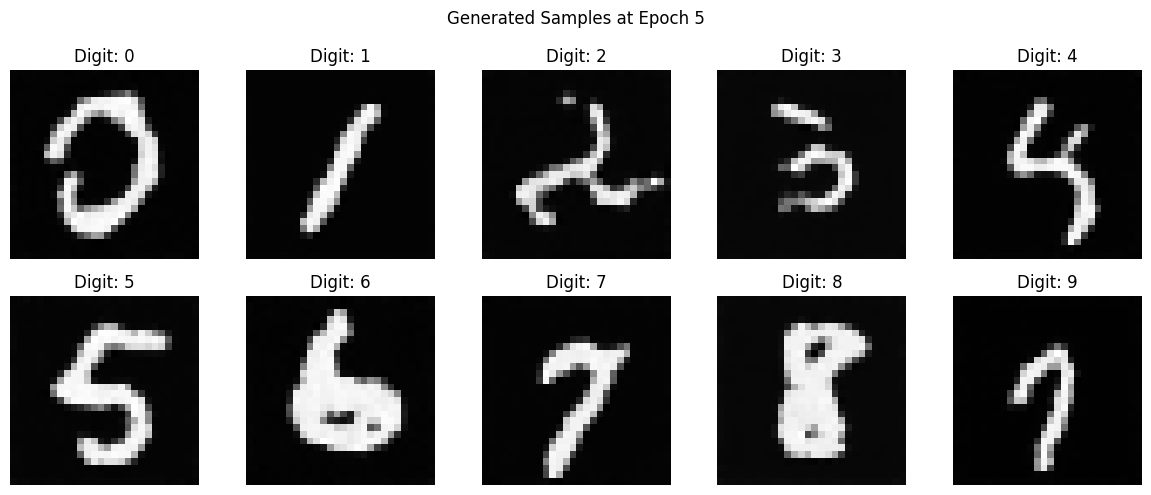

Epoch 6/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/40, Average Loss: 0.0375


Epoch 7/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/40, Average Loss: 0.0365


Epoch 8/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/40, Average Loss: 0.0362


Epoch 9/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/40, Average Loss: 0.0352


Epoch 10/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/40, Average Loss: 0.0345


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

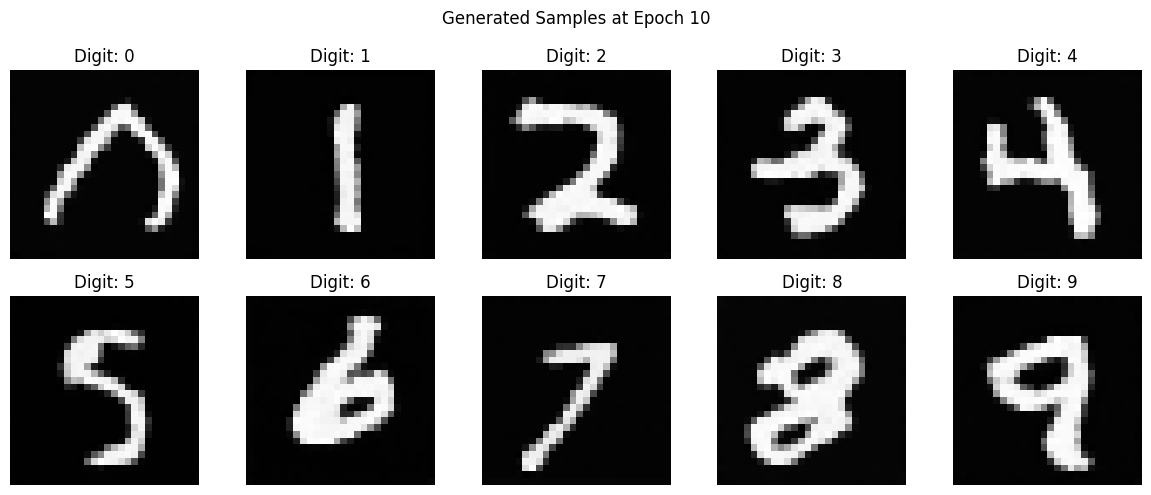

Epoch 11/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/40, Average Loss: 0.0345


Epoch 12/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/40, Average Loss: 0.0339


Epoch 13/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/40, Average Loss: 0.0335


Epoch 14/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/40, Average Loss: 0.0335


Epoch 15/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/40, Average Loss: 0.0332


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

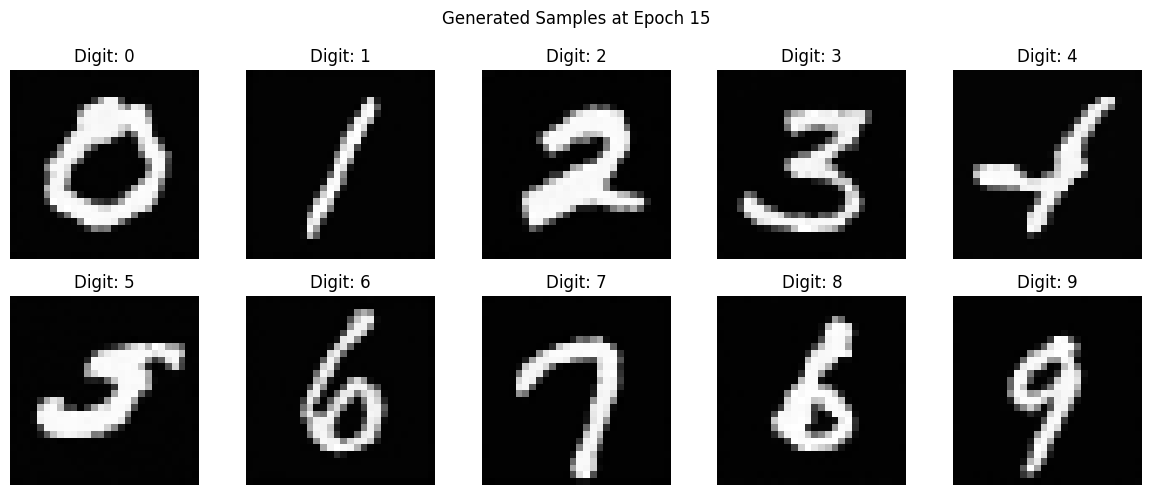

Epoch 16/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/40, Average Loss: 0.0329


Epoch 17/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/40, Average Loss: 0.0328


Epoch 18/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/40, Average Loss: 0.0327


Epoch 19/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/40, Average Loss: 0.0323


Epoch 20/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/40, Average Loss: 0.0323


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

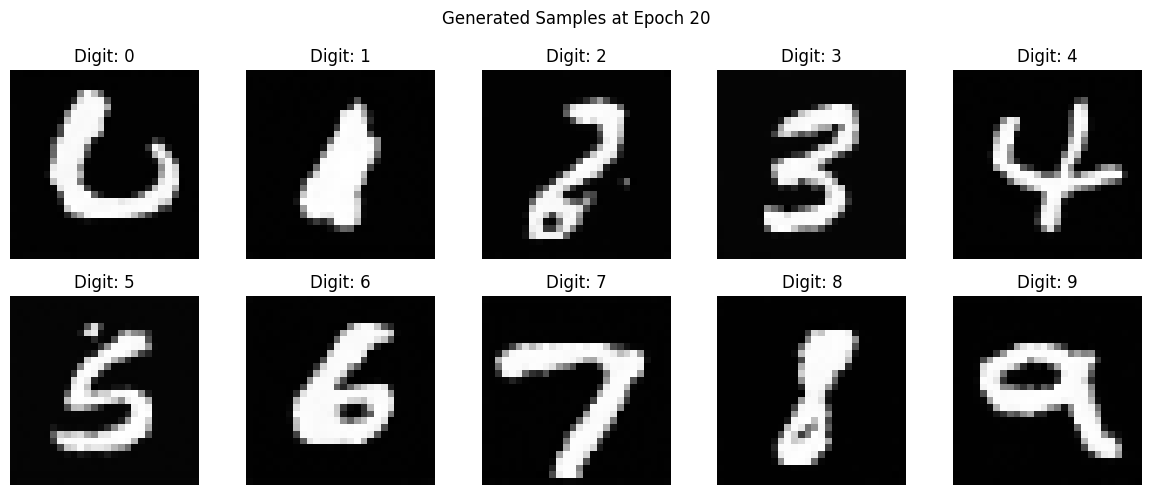

Epoch 21/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21/40, Average Loss: 0.0321


Epoch 22/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22/40, Average Loss: 0.0322


Epoch 23/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23/40, Average Loss: 0.0318


Epoch 24/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24/40, Average Loss: 0.0319


Epoch 25/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25/40, Average Loss: 0.0316


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

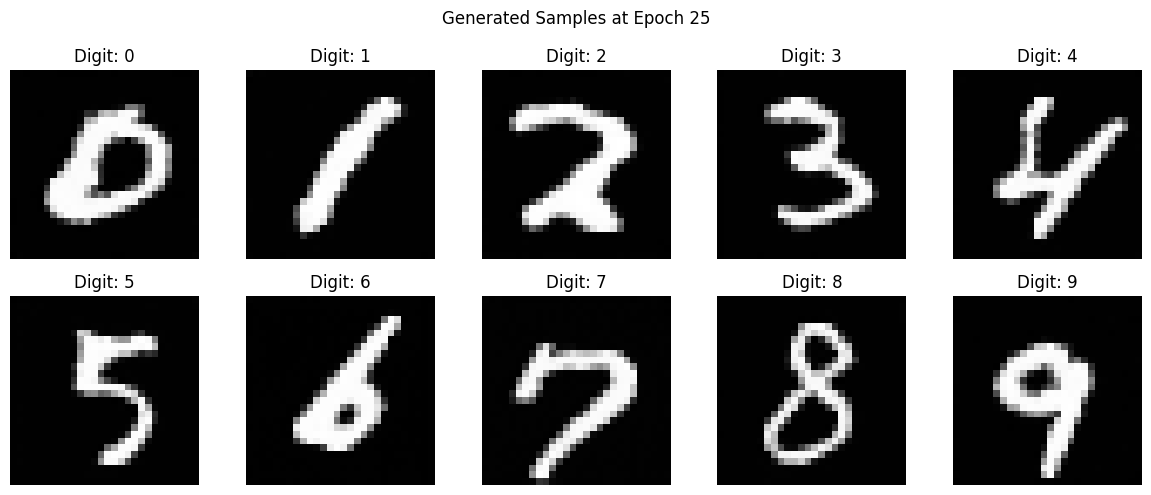

Epoch 26/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26/40, Average Loss: 0.0317


Epoch 27/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27/40, Average Loss: 0.0314


Epoch 28/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28/40, Average Loss: 0.0317


Epoch 29/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29/40, Average Loss: 0.0313


Epoch 30/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30/40, Average Loss: 0.0309


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

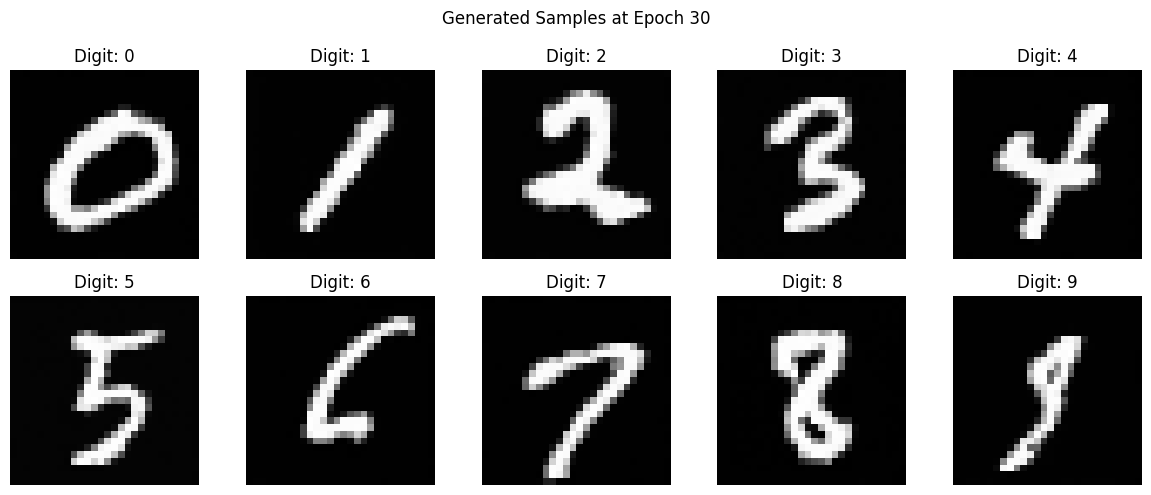

Epoch 31/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31/40, Average Loss: 0.0314


Epoch 32/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32/40, Average Loss: 0.0311


Epoch 33/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33/40, Average Loss: 0.0312


Epoch 34/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34/40, Average Loss: 0.0308


Epoch 35/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35/40, Average Loss: 0.0309


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

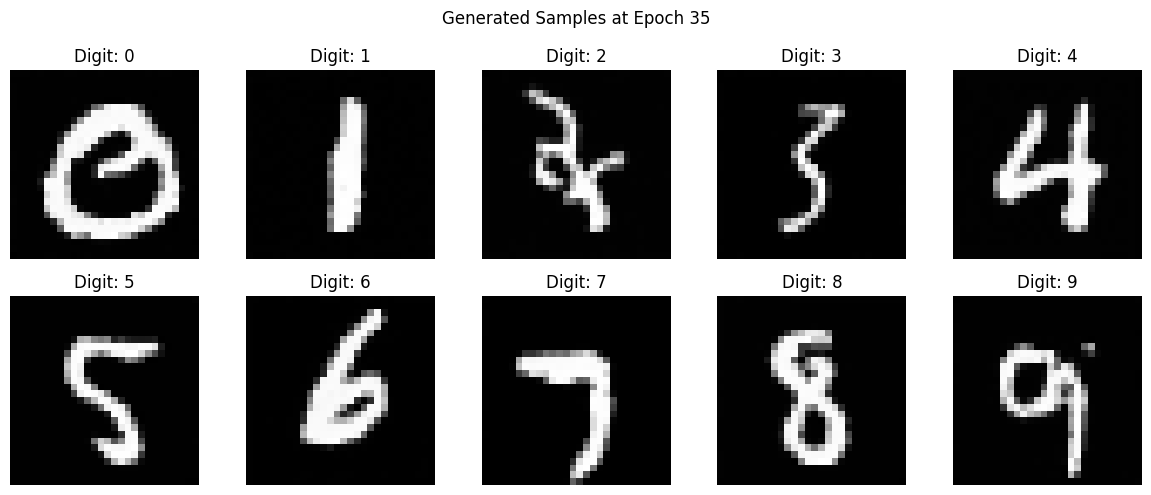

Epoch 36/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36/40, Average Loss: 0.0309


Epoch 37/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37/40, Average Loss: 0.0309


Epoch 38/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38/40, Average Loss: 0.0307


Epoch 39/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39/40, Average Loss: 0.0306


Epoch 40/40:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40/40, Average Loss: 0.0306


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

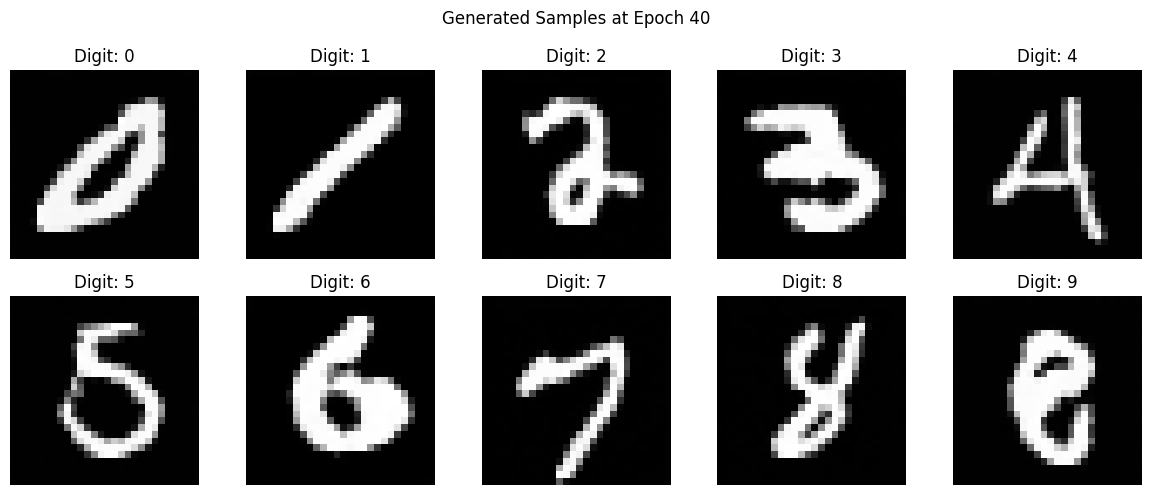

In [ ]:
diffusion = DiffusionProcess(timesteps=500, beta_start=1e-4, beta_end=0.02)

# Instantiate the U-Net model
model = ConditionalUNet(
    in_channels=1,
    model_channels=64,
    out_channels=1,
    num_classes=10,
    time_emb_dim=128,
    dropout=0.1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 40

losses = train(model, diffusion, train_loader, optimizer, num_epochs, device)


### 12. Sample Generation After Training
-   `generate_samples`: Generates and displays one image for each digit (0-9) to showcase the trained model's overall performance.
-   `generate_many_samples`: Generates multiple diverse samples for a single specified digit, demonstrating the model's generative capability.
-   The subsequent cell executes these functions to show results.

In [ ]:
def generate_samples(model, diffusion, device):
    """
    Generate and display samples for each digit
    """
    model.eval()


    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    with torch.no_grad():
        for digit in range(10):
            # Create label tensor for current digit
            label = torch.tensor([digit]).to(device)

            sample = diffusion.p_sample_loop(model, (1, 28, 28), label)

            # Denormalize and plot
            sample = sample * 0.5 + 0.5
            axes[digit].imshow(sample[0].cpu().squeeze(), cmap='gray')
            axes[digit].set_title(f"Generated Digit: {digit}")
            axes[digit].axis('off')

    plt.tight_layout()
    plt.suptitle("Conditional Diffusion Model: Generated MNIST Digits", fontsize=16)
    plt.show()



In [ ]:
# Generate multiple samples for a chosen digit
def generate_many_samples(model, diffusion, device, digit, num_samples=10):
    """
    Generate multiple samples for a specific digit
    """
    model.eval()

    rows = int(np.ceil(num_samples / 5))
    fig, axes = plt.subplots(rows, 5, figsize=(15, 3*rows))
    axes = axes.flatten()

    labels = torch.full((num_samples,), digit, dtype=torch.long, device=device)


    with torch.no_grad():
        samples = diffusion.p_sample_loop(model, (1, 28, 28), labels)
        samples = samples * 0.5 + 0.5  # Denormalize

        for i in range(num_samples):
            if i < len(axes):
                axes[i].imshow(samples[i].cpu().squeeze(), cmap='gray')
                axes[i].set_title(f"Sample {i+1}")
                axes[i].axis('off')

    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle(f"Multiple Samples of Digit {digit}", fontsize=16)
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

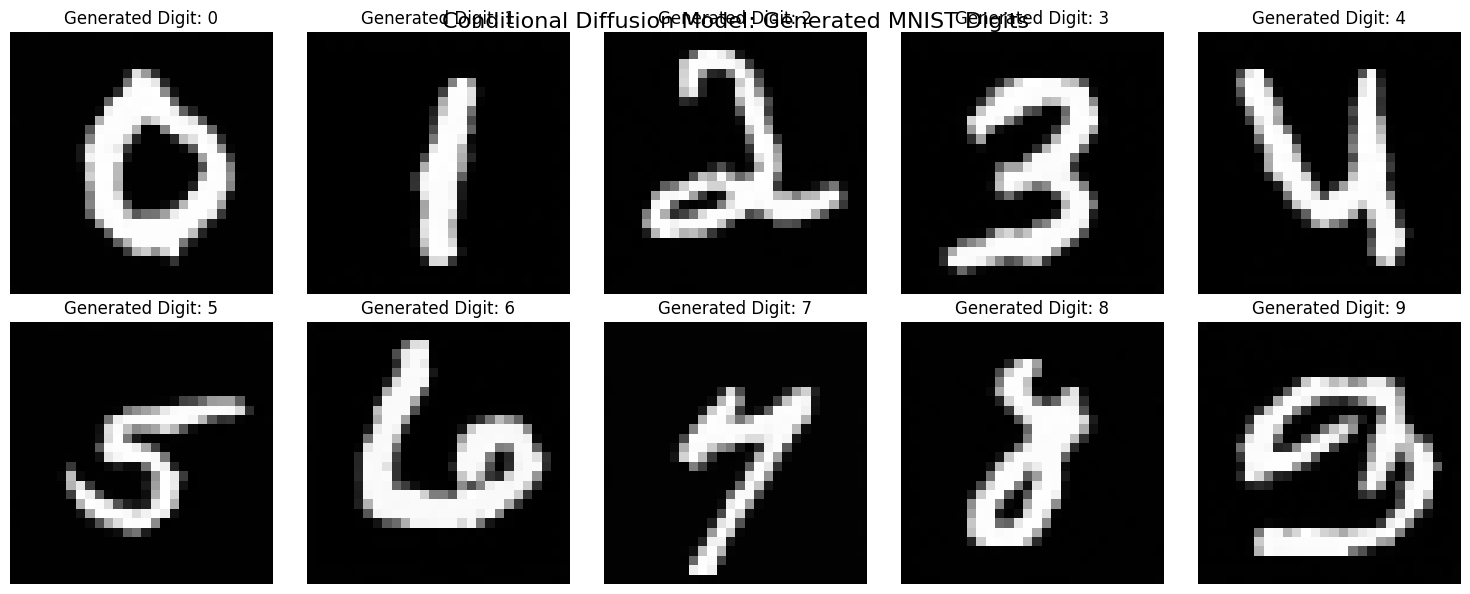

  0%|          | 0/500 [00:00<?, ?it/s]

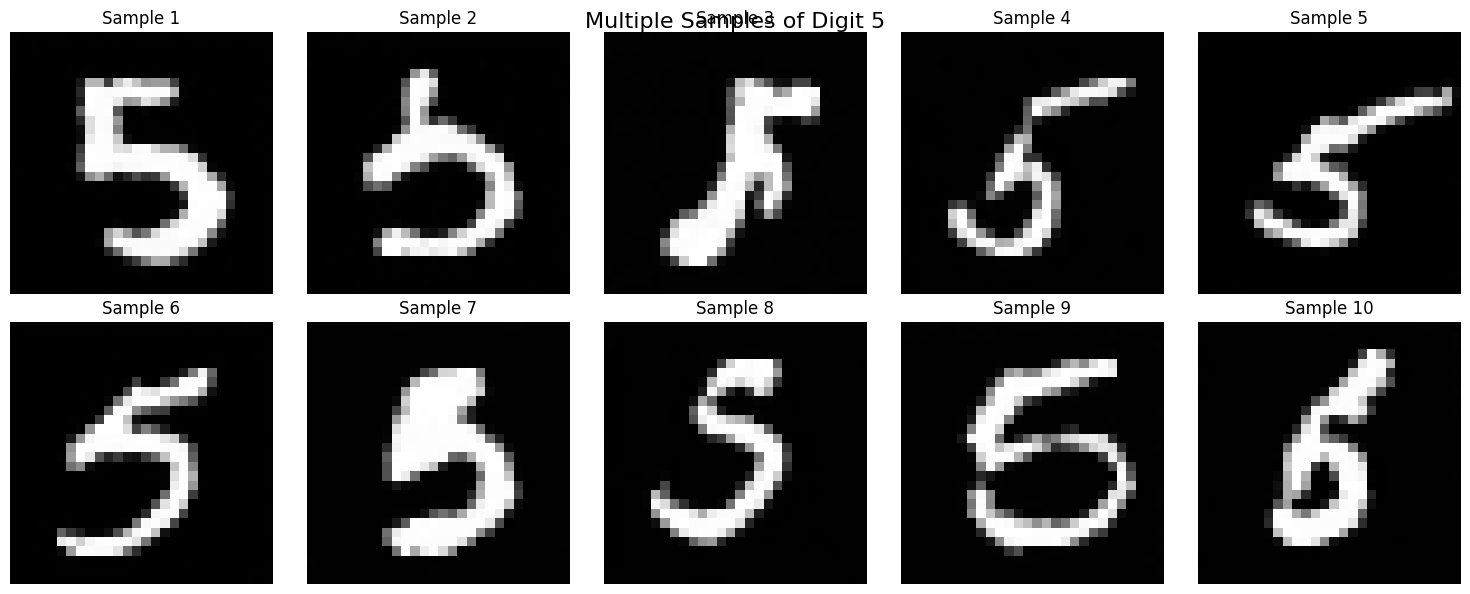

In [ ]:
generate_samples(model, diffusion, device)

# Generate 10 different samples of digit 5
generate_many_samples(model, diffusion, device, digit=5, num_samples=10)


### 13. Interactive Sample Generation
Uses `ipywidgets.interact` to create a slider that allows users to select a digit (0-9). The `generate_interactive` function is then called to generate and display an image of the selected digit.

In [ ]:
# uncomment and run the command below ipywidgets if not already installed on your device/VM
# pip install ipywidgets

In [ ]:
from ipywidgets import interact, IntSlider

@interact(digit=IntSlider(min=0, max=9, step=1, value=0))
def generate_interactive(digit):
    """
    Interactive widget to generate samples for a chosen digit
    """
    label = torch.tensor([digit]).to(device)

    # Generate sample
    with torch.no_grad():
        sample = diffusion.p_sample_loop(model, (1, 28, 28), label)
        sample = sample * 0.5 + 0.5  # Denormalize

    plt.figure(figsize=(5, 5))
    plt.imshow(sample[0].cpu().squeeze(), cmap='gray')
    plt.title(f"Generated Digit: {digit}")
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=0, description='digit', max=9), Output()), _dom_classes=('widget-interac…

### 14. Model Saving and Loading
-   The trained model's `state_dict` (parameters) and the optimizer's state are saved to `mnist_diffusion_model.pth`.
-   A `load_model` function is defined to recreate the model architecture and load the saved weights. It's crucial to instantiate the model with the same architecture before loading its state.

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'mnist_diffusion_model.pth')

print("Model saved successfully.")

# Loading the model (for future use)
def load_model():
    checkpoint = torch.load('mnist_diffusion_model.pth')
    model = ConditionalUNet(
        in_channels=1,
        model_channels=64,
        out_channels=1,
        num_classes=10,
        time_emb_dim=128,
        dropout=0.1
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

Model saved successfully.


### 16. Animation Imports
Imports additional libraries needed for creating and displaying GIF animations of the diffusion process within the Jupyter Notebook, including `matplotlib.animation` and `IPython.display` utilities.

In [18]:

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import numpy as np
import time
import io
from IPython.display import display, Image
from tqdm.notebook import tqdm


### 17. Diffusion Process Animation
-   `create_diffusion_animation`: Generates an animated GIF visualizing the reverse diffusion process for a chosen digit.
    *   Starts with random noise $x_T$.
    *   Iteratively applies `p_sample` to denoise the image.
    *   Captures `num_frames` intermediate states (images) by rendering them to Matplotlib figures and storing their RGBA buffer. Each temporary figure is closed immediately after capturing its frame.
    *   Uses `FuncAnimation` to create the animation from the captured frames.
    *   Saves the animation as a GIF file using the Pillow writer.
    *   Displays the generated GIF in the Jupyter Notebook.
-   An interactive widget (`@interact`) is set up using `IntSlider` for `digit` and `IntText` for `num_frames` and `interval`, allowing users to customize and trigger the animation generation.
-   A direct call to `create_diffusion_animation` is also shown as an example.

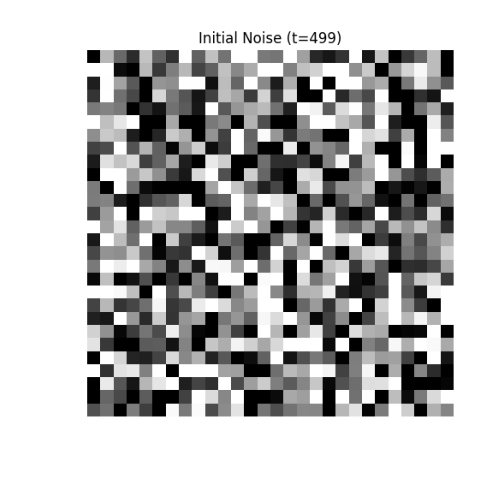

GIF saved at: diffusion_gifs/digit_7_generation_1743593522.gif


In [ ]:
from ipywidgets import interact, IntSlider, IntText 
import os

def create_diffusion_animation(model, diffusion, digit, device, num_frames=30, interval=200, save_dir="diffusion_gifs"):
    """
    Create an animation showing the reverse diffusion process for a specific digit.

    Args:
        model: The trained diffusion model.
        diffusion: The diffusion process object.
        digit: The digit to generate (0-9).
        device: Device to run the model on.
        num_frames: Number of frames to show (will sample evenly from timesteps).
        interval: Delay between frames in milliseconds.
        save_dir: Directory to save the GIF file.

    Returns:
        Path to the saved GIF, or None if failed.
    """
    model.eval()
    os.makedirs(save_dir, exist_ok=True) # Ensure save directory exists
    gif_path = os.path.join(save_dir, f'digit_{digit}_generation_{int(time.time())}.gif') # Unique filename

    # Prepare the conditioning label
    label = torch.tensor([digit], device=device)

    # Start with random noise (this is x_T)
    x = torch.randn(1, 1, 28, 28, device=device)

    # --- Define which timesteps to capture for the animation ---
    total_steps = diffusion.timesteps
    if total_steps < 1:
        print("Error: Diffusion timesteps must be at least 1.")
        return None
    # Select evenly spaced timesteps from T-1 down to 0
    # Ensure linspace covers the full range including 0 and T-1 if possible
    capture_indices = np.linspace(total_steps - 1, 0, num_frames, dtype=int)
    # Ensure uniqueness and sorted descending order (optional but good practice)
    capture_indices = np.unique(capture_indices)[::-1]
    capture_steps = set(capture_indices) # Use a set for efficient lookup

    # --- Store frames ---
    frames = []

    # --- Run the FULL reverse diffusion process ---
    progress_bar = tqdm(reversed(range(0, total_steps)), total=total_steps,
                        desc=f"Generating animation frames for digit {digit}")

    # Capture the initial noise state if requested
    if total_steps - 1 in capture_steps:
        try:
            # Create a temporary figure JUST for this frame
            fig_frame, ax_frame = plt.subplots(figsize=(5, 5))
            plt.tight_layout()

            img_display = x.clone().detach()
            img_display = (img_display * 0.5 + 0.5).clamp(0, 1) # Denormalize
            img_display = img_display[0, 0].cpu().numpy()

            ax_frame.imshow(img_display, cmap='gray', vmin=0, vmax=1)
            ax_frame.set_title(f"Initial Noise (t={total_steps-1})")
            ax_frame.axis('off')
            fig_frame.canvas.draw() # Render the canvas
            buf = fig_frame.canvas.buffer_rgba()
            image = np.asarray(buf)
            frames.append(image)
            plt.close(fig_frame) # Close the figure immediately after use
        except Exception as e:
            print(f"Error capturing initial frame: {e}")
            plt.close(fig_frame) # Ensure closure even on error


    for t_val in progress_bar:
        t_batch = torch.full((1,), t_val, device=device, dtype=torch.long)

        # Perform one denoising step: x_t -> x_{t-1}
        with torch.no_grad():
            x = diffusion.p_sample(model, x, t_batch, label)

        # Check if the step *just completed* (t_val) should be captured
        current_t_for_capture = t_val

        if current_t_for_capture in capture_steps:
            try:
                # -------- Create a NEW figure/axes for EACH frame --------
                fig_frame, ax_frame = plt.subplots(figsize=(5, 5))
                plt.tight_layout()
                # --------------------------------------------------------

                # Prepare image for display
                img_display = x.clone().detach() # Crucial: Clone the current state
                img_display = (img_display * 0.5 + 0.5).clamp(0, 1) # Denormalize
                img_display = img_display[0, 0].cpu().numpy()

                # Draw frame
                ax_frame.imshow(img_display, cmap='gray', vmin=0, vmax=1)
                ax_frame.set_title(f"Generating digit {digit}, Step {t_val}")
                ax_frame.axis('off')
                fig_frame.canvas.draw() # Render the canvas

                # Capture frame from buffer
                buf = fig_frame.canvas.buffer_rgba()
                image = np.asarray(buf) # Create numpy array from buffer
                frames.append(image)

                # -------- Close the temporary figure IMMEDIATELY --------
                plt.close(fig_frame)
                # --------------------------------------------------------
            except Exception as e:
                 print(f"Error capturing frame at step {t_val}: {e}")
                 plt.close(fig_frame) # Ensure closure even on error

    # --- Verify captured frames (optional debugging) ---
    if len(frames) > 1:
        # Check if first and last captured frames are different by comparing sums
        sum1 = frames[0].sum()
        sum_last = frames[-1].sum()
        print(f"Captured {len(frames)} frames. First sum: {sum1}, Last sum: {sum_last}")
        if sum1 == sum_last and len(frames) > 10: # Arbitrary check
             print("Warning: First and last captured frames seem identical. Check capture logic.")
    elif frames:
        print(f"Captured {len(frames)} frame.")
    else:
        print("Warning: No frames were captured. Check num_frames and diffusion.timesteps.")
        return None

    # --- Create the actual animation ---
    if not frames:
        return None

    # Create the figure for the animation itself
    fig_anim, ax_anim = plt.subplots(figsize=(5, 5))
    plt.tight_layout()
    ax_anim.axis('off') # Turn off axis for the final animation display

    # Set the initial image - crucial for blit=True
    im = ax_anim.imshow(frames[0])

    def animate(i):
        # Update the image data for the current frame
        im.set_array(frames[i])
        # Optional: update title dynamically if needed
        # ax_anim.set_title(f"Frame {i+1}/{len(frames)}")
        return [im] # Return iterable artist(s) for blitting

    # Create animation - try blit=False if True still causes issues
    anim = FuncAnimation(fig_anim, animate, frames=len(frames), interval=interval, blit=True)

    # Save as GIF
    try:
        # Use Pillow writer
        anim.save(gif_path, writer='pillow', fps=int(1000 / interval))
        print(f"Animation saved to {gif_path}")
    except Exception as e:
        print(f"Error saving animation: {e}")
        print("Ensure Pillow is installed (`pip install Pillow`) and you have permissions.")
        plt.close(fig_anim) # Close animation figure on error
        return None

    plt.close(fig_anim) # Close the animation figure after saving

    # Display the GIF in the notebook
    clear_output(wait=True) # Clear previous plots/outputs before showing GIF
    try:
        with open(gif_path, 'rb') as f:
            display(Image(data=f.read(), format='gif')) # Specify format='gif'
    except FileNotFoundError:
        print(f"Could not find saved GIF at {gif_path}")
        return None
    except Exception as e:
        print(f"Error displaying GIF: {e}")
        return None

    return gif_path # Return path

# --- How to use ---

# Example call within the interactive widget remains the same:
@interact(
    digit=IntSlider(min=0, max=9, step=1, value=3, description='Digit:'),
    num_frames=IntText(value=50, description='Frames:', step=5),
    interval=IntText(value=100, description='Interval (ms):', step=10)
)
def generate_animation(digit, num_frames, interval):
    # Optional: Clear previous plots if you see multiple static plots appearing
    # plt.close('all')
    # clear_output(wait=True) # Already done inside create_diffusion_animation before display
    gif_path = create_diffusion_animation(
        model, diffusion, digit, device,
        num_frames=num_frames, interval=interval, save_dir="diffusion_gifs" # Specify save dir
    )
    # No return needed for interact, display happens inside

# Example: Create animation for digit 7 directly
gif_file = create_diffusion_animation(model, diffusion, 7, device, num_frames=60, interval=80)
if gif_file:
   print(f"GIF saved at: {gif_file}")